In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# First, define device setup
def setup_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
        torch.set_default_device(device)
        print("Using MPS device")
    else:
        device = torch.device("cpu")
        print("MPS not available, using CPU")
    return device

# Set global device
device = setup_device()

In [ ]:
data = pd.read_csv("riceClassification.csv")

In [ ]:
data.dropna(inplace=True)
data.drop("id", axis=1, inplace=True)

In [5]:
original_df = data.copy()
for column in data.columns:
  data[column] = data[column]/max(data[column])

In [6]:
X = np.array(data.iloc[:, :-1])
Y = np.array(data.iloc[:, -1])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [7]:
X_test, X_validation, Y_test, Y_validation = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

In [8]:
print(X_train.shape, X_test.shape, X_validation.shape)

(12729, 10) (2728, 10) (2728, 10)


In [12]:
class ricedataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.Y = torch.tensor(Y, dtype=torch.float32)
  def __len__(self):
    return len(self.X)
  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [13]:
training_data = ricedataset(X_train, Y_train)
validation_data = ricedataset(X_validation, Y_validation)
testing_data = ricedataset(X_test, Y_test)

In [14]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)

In [16]:
HIDDEN_NEURONS = 10
class model(nn.Module):
  def __init__(self):
    super(model, self).__init__()
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = model()

In [17]:
summary(model, input_size=(X.shape[1],))

Layer (type:depth-idx)                   Output Shape              Param #
model                                    [1]                       --
├─Linear: 1-1                            [10]                      110
├─Linear: 1-2                            [1]                       11
├─Sigmoid: 1-3                           [1]                       --
Total params: 121
Trainable params: 121
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [19]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-4)

In [21]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_accuracy_train_plot = []
total_accuracy_validation_plot = []
# Debug device placement
epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_validation = 0
  total_loss_validation = 0
  for data in train_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()
    acc = ((prediction.round()) == labels).sum().item()
    total_acc_train += acc
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()
      acc = ((prediction.round()) == labels).sum().item()
      total_acc_validation += acc
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_validation/1000, 4))
  total_accuracy_train_plot.append(round(total_acc_train/len(train_dataloader.dataset) * 100, 4))
  total_accuracy_validation_plot.append(round(total_acc_validation/len(validation_dataloader.dataset) * 100, 4))

  print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss_train_plot[-1]} | Train Accuracy: {total_accuracy_train_plot[-1]} | Validation Loss: {total_loss_validation_plot[-1]} | Validation Accuracy: {total_accuracy_validation_plot[-1]}")
  print("-"*50)

Epoch 1/10 | Train Loss: 0.2024 | Train Accuracy: 97.541 | Validation Loss: 0.0424 | Validation Accuracy: 97.4707
--------------------------------------------------
Epoch 2/10 | Train Loss: 0.192 | Train Accuracy: 97.7296 | Validation Loss: 0.0401 | Validation Accuracy: 97.324
--------------------------------------------------
Epoch 3/10 | Train Loss: 0.1814 | Train Accuracy: 97.7689 | Validation Loss: 0.0378 | Validation Accuracy: 97.5806
--------------------------------------------------
Epoch 4/10 | Train Loss: 0.1709 | Train Accuracy: 97.7767 | Validation Loss: 0.0356 | Validation Accuracy: 98.4604
--------------------------------------------------
Epoch 5/10 | Train Loss: 0.1605 | Train Accuracy: 98.0517 | Validation Loss: 0.0333 | Validation Accuracy: 97.8739
--------------------------------------------------
Epoch 6/10 | Train Loss: 0.1503 | Train Accuracy: 98.0203 | Validation Loss: 0.0312 | Validation Accuracy: 98.0938
--------------------------------------------------
Epoch 7

In [22]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_test += batch_loss
    acc = ((prediction.round()) == labels).sum().item()
    total_acc_test += acc

print(f"Test Accuracy: {round(total_acc_test/testing_data.__len__() * 100, 4)}")

Test Accuracy: 98.5337


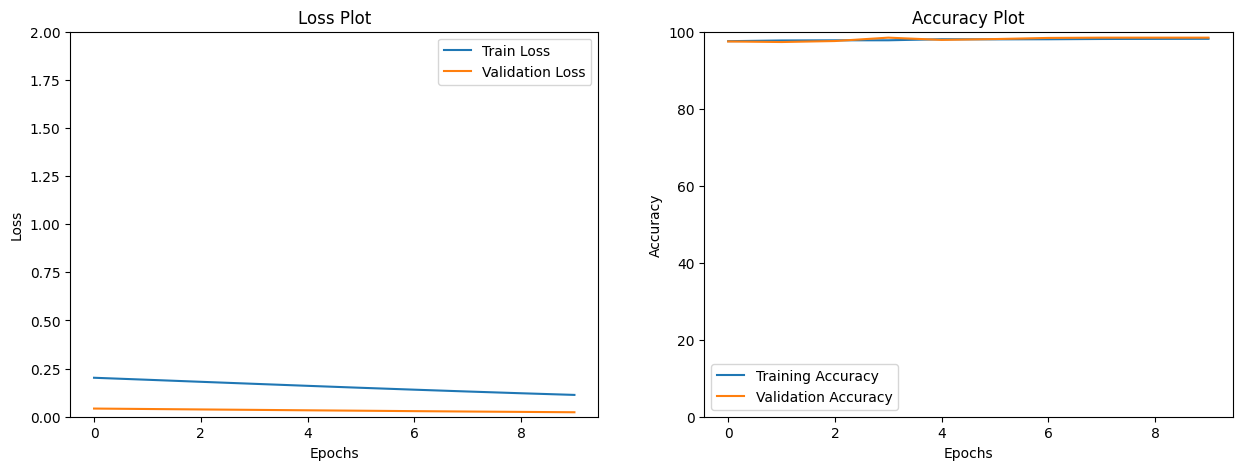

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_validation_plot, label="Validation Loss")
axs[0].set_title("Loss Plot")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_accuracy_train_plot, label="Training Accuracy")
axs[1].plot(total_accuracy_validation_plot, label="Validation Accuracy")
axs[1].set_title("Accuracy Plot")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [25]:
area = 3000/original_df['Area'].abs().max()
MajorAxisLength = 80/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 42/original_df['MinorAxisLength'].abs().max()
Eccentricity = 0.75/original_df['Eccentricity'].abs().max()
ConvexArea = 3500/original_df['ConvexArea'].abs().max()
EquivDiameter = 45/original_df['EquivDiameter'].abs().max()
Extent = 0.75/original_df['Perimeter'].abs().max()
Perimeter = 150/original_df['Perimeter'].abs().max()
Roundness = 0.75/original_df['Roundness'].abs().max()
AspectRation = 1.3/original_df['AspectRation'].abs().max()

with torch.inference_mode():
  data_inference = torch.tensor([[area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]], dtype=torch.float32)
  prediction = model(data_inference)
  print(prediction)

tensor([[0.]])
